In [1]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

<IPython.core.display.Javascript object>

## Data Preprocessing

* Regex cheatsheet
    * https://www.rexegg.com/regex-quickstart.html
* Regex test - live
    * https://regexr.com/
* Datetime format
    * http://strftime.org/

In [2]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding ='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

### Import data

In [5]:
df = rawToDf('WhatsApp Chat with Kibbcom India.txt', '12hr')

In [6]:
df.tail()

date_time             user    msg
3416 2020-01-09 11:51:00           Shuchi  Done 
3417 2020-01-09 12:03:00  +91 90039 29873  Done 
3418 2020-01-09 12:03:00    Shalini Gupta  Done 
3419 2020-01-09 12:22:00          Nitisha  Done 
3420 2020-01-09 12:29:00  +91 94801 22369  Done

In [7]:
df.shape # no. of msgs

(3421, 3)

In [9]:
me = "Shuchi"

### Data Cleaning

In [10]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

(286, 3)

In [11]:
df["user"].unique()

array(['grp_notif', 'Rajat', 'Ankush Gattewar', 'Akshay', 'Nitisha',
       'Shrey', '+91 88878 81443', 'Shuchi', 'Shivya', '+91 82888 63631',
       'Amandeep Singh', '+91 70891 31084', 'Suresh', 'tiwari ji',
       'Gautam Shandilya', 'Nita', 'Neha', 'Rajat A', 'Rantu Das',
       'Sumit Joshi', 'Shubham Sony', 'Farhan Ashraf', 'Izra Qadari',
       'Sikha', 'Vijya', '+91 90039 29873', 'Suri Bhai',
       '+91 94801 22369', '+91 89723 95343', 'Shalini Gupta',
       '+91 79813 24240', '+91 81979 33656', '+91 90624 25142'],
      dtype=object)

In [12]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(32, 3)

In [13]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [14]:
df.tail()

date_time             user    msg
3416 2020-01-09 11:51:00           Shuchi  Done 
3417 2020-01-09 12:03:00  +91 90039 29873  Done 
3418 2020-01-09 12:03:00    Shalini Gupta  Done 
3419 2020-01-09 12:22:00          Nitisha  Done 
3420 2020-01-09 12:29:00  +91 94801 22369  Done

In [15]:
df.reset_index(inplace=True, drop=True)
df.shape

(3103, 3)

# Lets Discuss on what do we want to get out of this data
    * Is raw data enough to get that insight?
    * if not what can be possible way to get that insight?
    * Whats the use of that insight?
    
**Questions from the audience**

## Q 1) Who is the most active member of the group. Who is the least active?

In [16]:
df.groupby("user")["msg"].count().sort_values(ascending=False)

user
Rajat               699
Akshay              403
Shuchi              388
Shrey               222
Ankush Gattewar     200
Nita                129
Neha                113
Shivya              104
Amandeep Singh      101
Gautam Shandilya     79
tiwari ji            78
Sumit Joshi          77
+91 90039 29873      61
Rantu Das            60
+91 70891 31084      54
Nitisha              46
Shubham Sony         44
Suresh               43
Farhan Ashraf        41
Rajat A              35
Izra Qadari          33
Suri Bhai            27
+91 88878 81443      17
+91 94801 22369      14
Shalini Gupta         9
+91 90624 25142       6
+91 89723 95343       6
+91 82888 63631       4
Sikha                 3
Vijya                 3
+91 81979 33656       2
+91 79813 24240       2
Name: msg, dtype: int64

## Q 2) Count of all the emojis that i have used?

In [17]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [18]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

🏻 - 101
🤭 - 67
🤣 - 59
♀ - 57
🤦 - 43
😂 - 25
😍 - 24
👻 - 24
👏 - 23
😱 - 18


## Q 3) What can my activity say about my sleep cycle?

In [19]:
def to_hour(val):
    return val.hour

In [20]:
df['hour'] = df['date_time'].apply(to_hour)

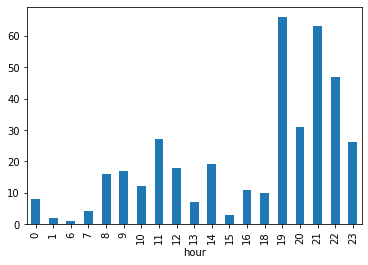

In [21]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [22]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [23]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [24]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

Rajat               699
Akshay              403
Shuchi              388
Shrey               222
Ankush Gattewar     200
Nita                129
Neha                113
Shivya              104
Amandeep Singh      101
Gautam Shandilya     79
tiwari ji            78
Sumit Joshi          77
+91 90039 29873      61
Rantu Das            60
+91 70891 31084      54
Nitisha              46
Shubham Sony         44
Suresh               43
Farhan Ashraf        41
Rajat A              35
Izra Qadari          33
Suri Bhai            27
+91 88878 81443      17
+91 94801 22369      14
Shalini Gupta         9
+91 90624 25142       6
+91 89723 95343       6
+91 82888 63631       4
Vijya                 3
Sikha                 3
+91 81979 33656       2
+91 79813 24240       2
Name: user, dtype: int64

In [25]:
top5_users = msgs_per_user.index.tolist()[:5]
top5_users

['Rajat', 'Akshay', 'Shuchi', 'Shrey', 'Ankush Gattewar']

In [26]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

date_time             user  \
0 2018-08-01 15:16:00            Rajat   
1 2018-08-01 15:30:00  Ankush Gattewar   
2 2018-08-01 15:30:00  Ankush Gattewar   
3 2018-08-02 13:42:00           Akshay   
5 2018-08-03 22:50:00            Shrey   

                                                 msg  hour    weekday  \
0  Welcome @917089131084 @918109627183 @917769884...    15  Wednesday   
1  @918550833000 Jonas had asked that how we can ...    15  Wednesday   
2                                     In crm system     15  Wednesday   
3                             Internet is working??     13   Thursday   
5  Everyone check your contact list for a no save...    22     Friday   

   is_weekend  
0       False  
1       False  
2       False  
3       False  
5       False

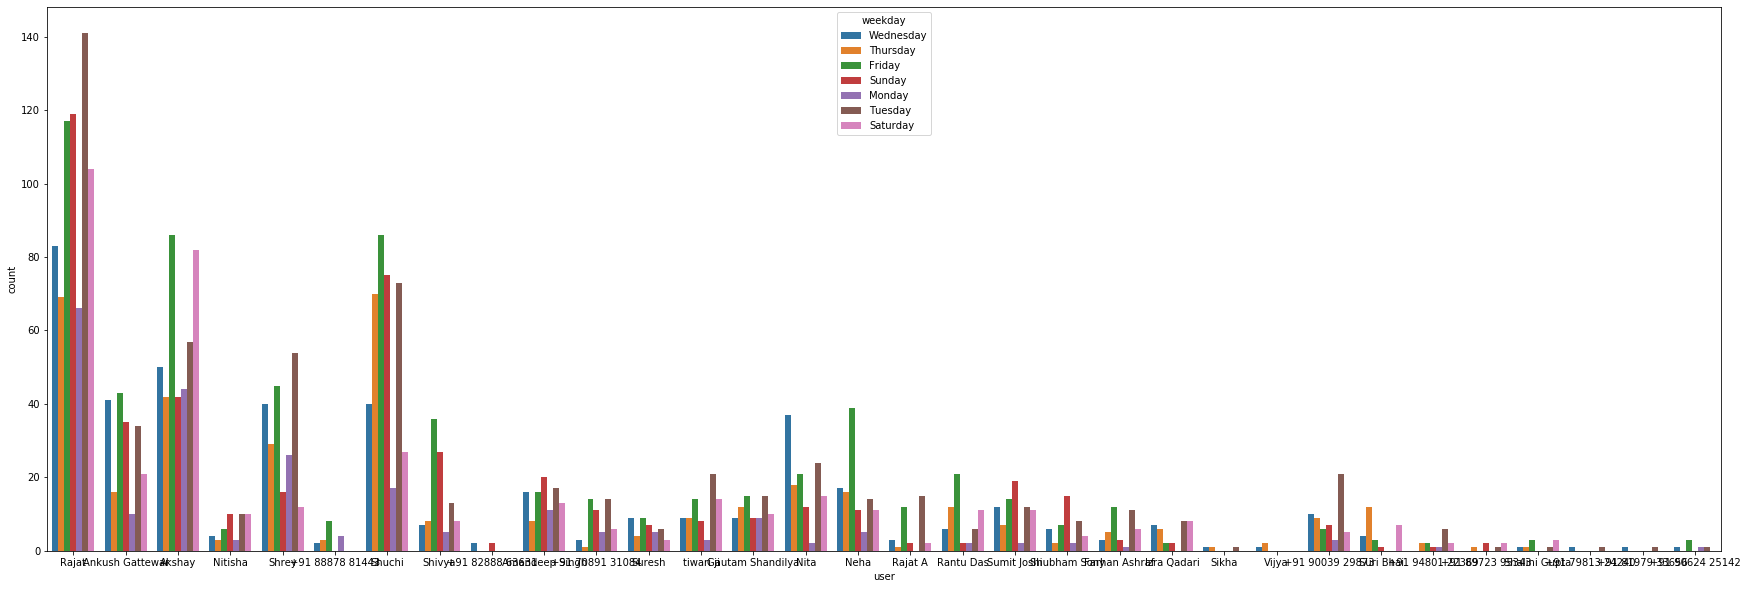

In [27]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

In [28]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

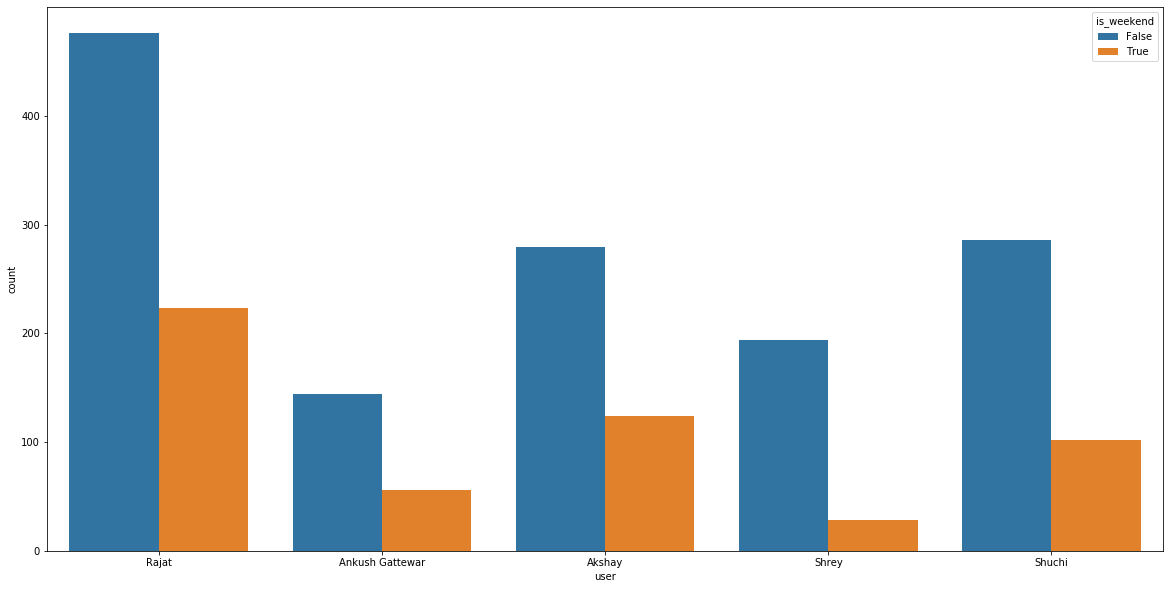

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

In [30]:
def word_count(val):
    return len(val.split())

In [31]:
df['no_of_words'] = df['msg'].apply(word_count)

In [32]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [33]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

10359

In [34]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

3905

In [35]:
total_words_weekday/5 # average words on a weekday

2071.8

In [36]:
total_words_weekend/2 # average words on a weekend

1952.5

In [37]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Rajat               3787
Akshay              1864
Shuchi              1178
Shrey               1015
Ankush Gattewar      952
Gautam Shandilya     601
Sumit Joshi          456
Nita                 456
Amandeep Singh       449
tiwari ji            430
Neha                 393
Shivya               339
+91 70891 31084      336
Rantu Das            300
+91 90039 29873      288
Shubham Sony         225
Farhan Ashraf        188
Rajat A              167
Nitisha              159
Suresh               140
Izra Qadari          130
+91 94801 22369       99
Suri Bhai             82
+91 88878 81443       78
Shalini Gupta         34
+91 90624 25142       30
Vijya                 29
+91 89723 95343       24
+91 82888 63631       15
Sikha                  9
+91 79813 24240        6
+91 81979 33656        5
Name: no_of_words, dtype: int64

In [38]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Rajat              5.417740
Ankush Gattewar    4.760000
Akshay             4.625310
Shrey              4.572072
Shuchi             3.036082
dtype: float64

In [39]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user             is_weekend
Akshay           False         4.637993
                 True          4.596774
Ankush Gattewar  False         4.909722
                 True          4.375000
Rajat            False         5.514706
                 True          5.210762
Shrey            False         4.479381
                 True          5.214286
Shuchi           False         3.045455
                 True          3.009804
dtype: float64

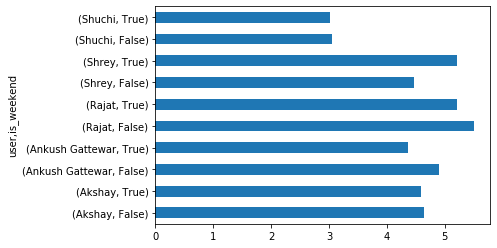

In [40]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

## Q 5)
## Most Usage - Time of Day

In [41]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
hour                                                                   
0           6.0     NaN       NaN     2.0      12.0     10.0       46.0
1           NaN     NaN       NaN     5.0       1.0      2.0        NaN
3           NaN     NaN       NaN     NaN       1.0      1.0        6.0
4           NaN     NaN       NaN     NaN       NaN      NaN        2.0
5           NaN     NaN       NaN     NaN       1.0      1.0        2.0

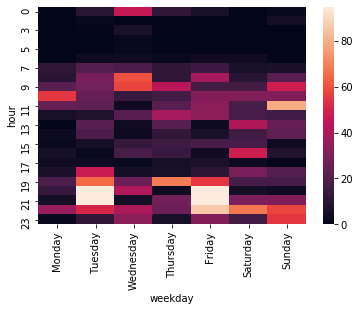

In [42]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6)
## In any group, do I have any inclination towards responding to someone? 

In [43]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[  10   12   13   17   18   33   37   42   44   52   53   62   63   85
   95   99  123  124  128  130  132  140  150  152  174  193  199  200
  203  204  205  208  211  243  244  246  248  249  250  252  254  256
  257  259  261  262  281  283  284  344  411  413  414  438  482  484
  491  518  519  525  527  528  535  536  537  538  541  562  564  569
  570  584  586  588  589  596  629  630  631  634  637  638  639  642
  643  644  647  649  650  662  664  667  682  683  685  688  692  694
  697  700  704  705  711  716  719  722  723  728  730  733  736  739
  740  753  754  775  776  779  780  781  783  786  787  789  798  799
  800  801  804  806  807  810  814  816  817  818  820  831  836  856
  857  858  860  861  865  866  876  878  879  881  885  886  887  889
  890  894  896  904  911  951  954  955  968  972  973  974  976  978
  987  988  989  994  996 1006 1007 1020 1021 1028 1029 1031 1054 1165
 1226 1228 1230 1231 1234 1235 1236 1243 1267 1315 1316 1431 1455 1457
 1488 

In [44]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[   9   11   12   16   17   32   36   41   43   51   52   61   62   84
   94   98  122  123  127  129  131  139  149  151  173  192  198  199
  202  203  204  207  210  242  243  245  247  248  249  251  253  255
  256  258  260  261  280  282  283  343  410  412  413  437  481  483
  490  517  518  524  526  527  534  535  536  537  540  561  563  568
  569  583  585  587  588  595  628  629  630  633  636  637  638  641
  642  643  646  648  649  661  663  666  681  682  684  687  691  693
  696  699  703  704  710  715  718  721  722  727  729  732  735  738
  739  752  753  774  775  778  779  780  782  785  786  788  797  798
  799  800  803  805  806  809  813  815  816  817  819  830  835  855
  856  857  859  860  864  865  875  877  878  880  884  885  886  888
  889  893  895  903  910  950  953  954  967  971  972  973  975  977
  986  987  988  993  995 1005 1006 1019 1020 1027 1028 1030 1053 1164
 1225 1227 1229 1230 1233 1234 1235 1242 1266 1314 1315 1430 1454 1456
 1487 

In [45]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(388, 7)

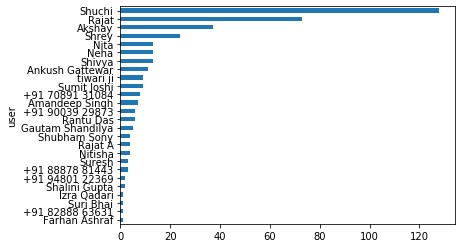

In [46]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

## Q 7)
## Which are the most common words?

In [47]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


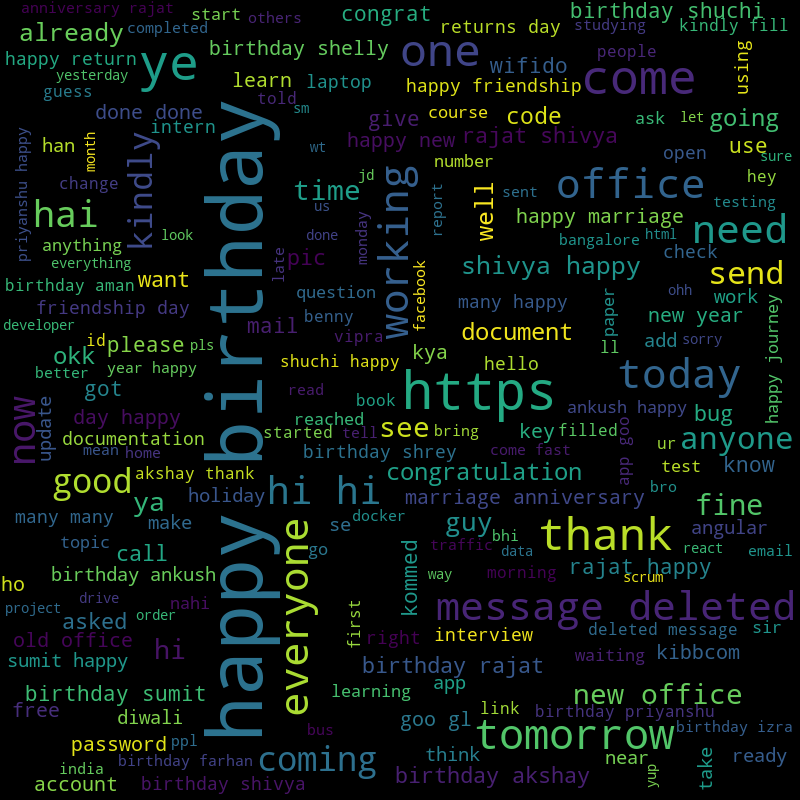

In [48]:
wordcloud.to_image()

## Know What They Know(atleast by little
* Let this meetup series encourage people to work on their own data:
    * Ask many questions on whatsapp chat data, commit to jovian with your answers/analysis visulization. Experiment!!!
* Explore more data resources here's a list i could find, share if you find any @ dsnet.org
    * WhatsApp
    * Google take out (https://takeout.google.com/)
        * Keyboard
        * Maps
        * Calendar 
        * Chrome
        * Pay
        * etc....
    * https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/
    * https://in.pcmag.com/software/120204/how-to-download-your-facebook-data-and-6-surprising-things-i-found
* Lets move step by step EDA first to try answer the questions on our own then move to some ML/DL Models 

## Assingment-kind
* 1way ya 2way, check for a response time between two people

In [ ]:
jovian.commit(notebook_id='PrajwalPrashanth/kwtk-whatsapp-refrence')

[jovian] Saving notebook..


<IPython.core.display.Javascript object>

[jovian] Git repository identified. Performing git commit...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: 